In [38]:
from rainbow_mouse.models.first_model import LFPChannelEmbeddingModel
import os
import numpy as np
from dotenv import load_dotenv
load_dotenv()
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [39]:
cache_path = os.environ.get("RAINBOW_MOUSE_CACHE")
lfp_train = np.load(f"{cache_path}/lfp_X.npy")[:,:118*30] 
print(lfp_train.shape)          # [95, 5900]
frames_train = np.load(f"{cache_path}/lfp_y.npy")[:118*30]     # [5900]
vit_embeddings = np.load(f"{cache_path}/vit_embeddings.npy")  # [95, 48]
lfp_test = np.load(f"{cache_path}/lfp_X.npy")[:,118*30:] 
print(lfp_test.shape)     # [95, 5900]
frames_test = np.load(f"{cache_path}/lfp_y.npy")[118*30:]-1   # [5900]

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LFPChannelEmbeddingModel()
PATH= f"{cache_path}/lfp_model.pth"
model.load_state_dict(torch.load(PATH))
model.eval()

(95, 3540)
(95, 2360)


LFPChannelEmbeddingModel(
  (channel_embed): Embedding(95, 16)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [25]:
5900/118

118*20

2360

Generating predictions for full test set...


  0%|          | 0/2360 [00:00<?, ?it/s]

100%|██████████| 2360/2360 [00:00<00:00, 8136.53it/s]


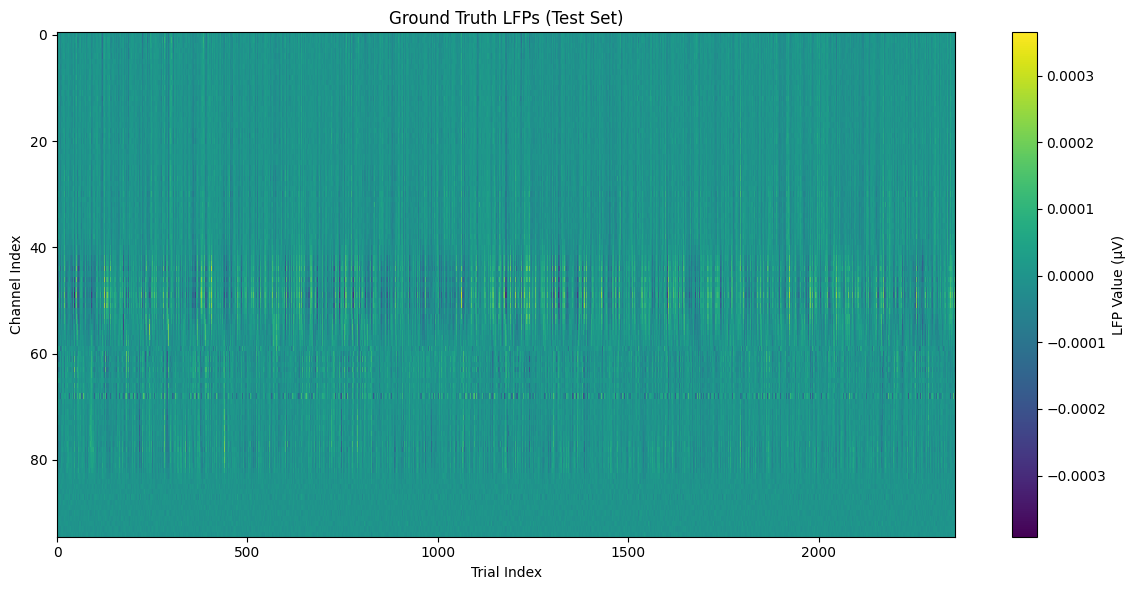

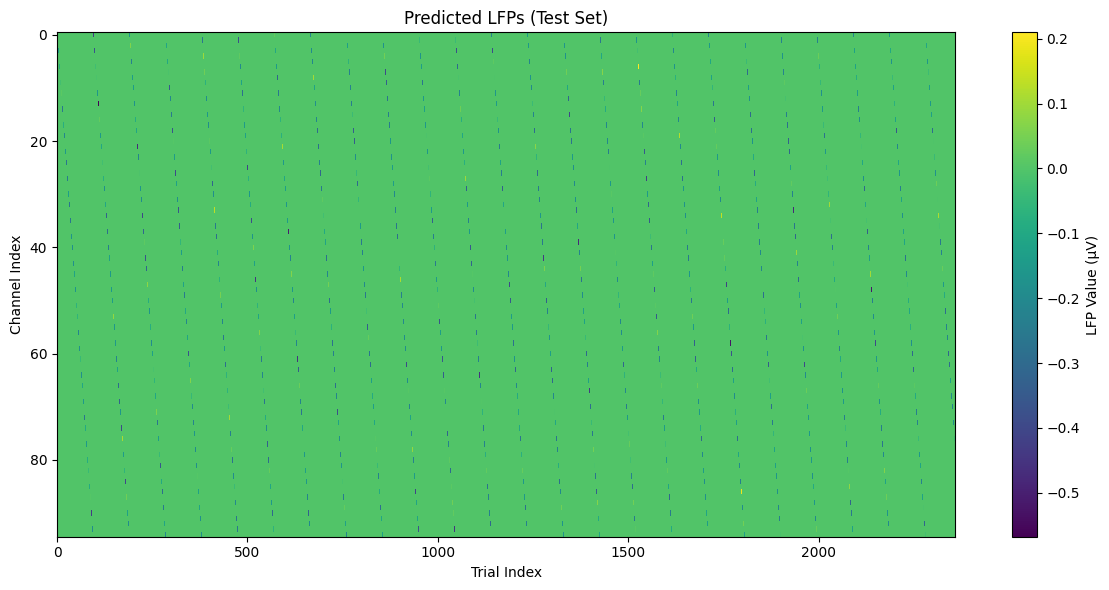

In [46]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Load data
cache_path = os.environ.get("RAINBOW_MOUSE_CACHE")
lfp_train = np.load(f"{cache_path}/lfp_X.npy")[:, :118*30]               # [95, 3540]
frames_train = np.load(f"{cache_path}/lfp_y.npy")[:118*30] -1              # [3540]
vit_embeddings = np.load(f"{cache_path}/vit_embeddings.npy")            # [118, 48]
lfp_test = np.load(f"{cache_path}/lfp_X.npy")[:, 118*30:]                # [95, 5900]
frames_test = np.load(f"{cache_path}/lfp_y.npy")[118*30:] - 1           # [5900], subtract 1 to align with ViT idx

lfp_train = (lfp_train - np.mean(lfp_train, axis=1, keepdims=True)) / np.std(lfp_train, axis=1, keepdims=True)
lfp_test = (lfp_test - np.mean(lfp_train, axis=1, keepdims=True)) / np.std(lfp_train, axis=1, keepdims=True)

# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LFPChannelEmbeddingModel().to(device)
model.load_state_dict(torch.load(f"{cache_path}/lfp_model.pth"))
model.eval()

# Predict full test set
n_channels, n_trials = lfp_test.shape
lfp_preds = np.zeros((n_channels, n_trials))

print("Generating predictions for full test set...")

for i in tqdm(range(n_trials)):
    frame_idx = frames_test[i]
    channel_idx = i % n_channels

    vit_input = torch.tensor(vit_embeddings[frame_idx], dtype=torch.float32).to(device)
    channel_tensor = torch.tensor([channel_idx], dtype=torch.long).to(device)

    with torch.no_grad():
        pred = model(vit_input.unsqueeze(0), channel_tensor).cpu().item()

    lfp_preds[channel_idx, i] = pred

# Plotting as heatmaps
def plot_lfp_heatmap(data, title):
    plt.figure(figsize=(12, 6))
    plt.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar(label='LFP Value (µV)')
    plt.title(title)
    plt.xlabel("Trial Index")
    plt.ylabel("Channel Index")
    plt.tight_layout()
    plt.show()

plot_lfp_heatmap(lfp_test, "Ground Truth LFPs (Test Set)")
plot_lfp_heatmap(lfp_preds, "Predicted LFPs (Test Set)")


In [41]:
lfp_preds.shape

(95, 2360)

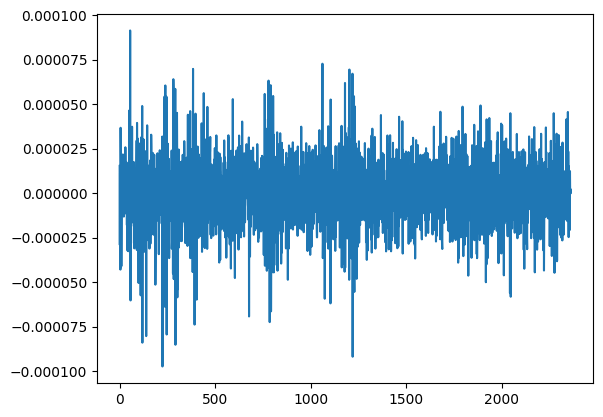

In [42]:
plt.plot(lfp_test[0,:], label="True LFP")

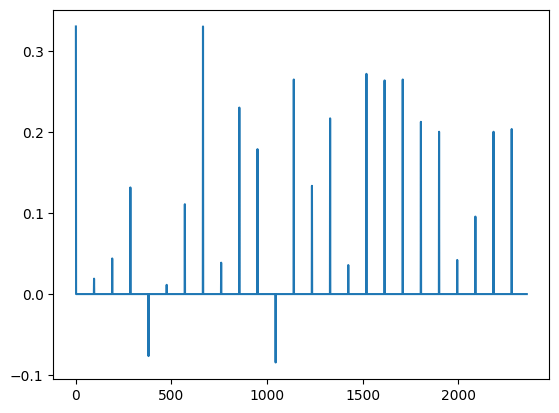

In [43]:
plt.plot(lfp_preds[0,:], label="Predicted LFP")

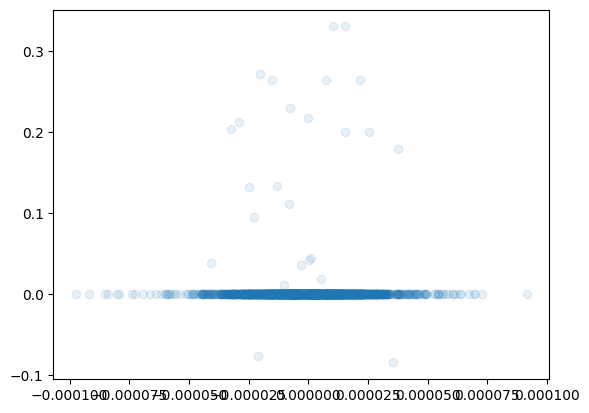

In [44]:
plt.scatter(lfp_test[0,:], lfp_preds[0,:], alpha=0.1, label="Predicted LFP vs True LFP")